In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.ticker as mtick
from scipy import stats
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

# Case Study: Maria Lentini
A/B test website redesign 2/15/17 - 4/30/17. 

In [2]:
# import data
# contains client demographic info
df_demo = pd.read_csv('df_final_demo.txt')

# contains web hit level web activity, part 1 and part 2
df_web1 = pd.read_csv('df_final_web_data_pt_1.txt')
df_web2 = pd.read_csv('df_final_web_data_pt_2.txt')

# convert date fields to datetime
df_web1['date_time'] = pd.to_datetime(df_web1['date_time'])
df_web2['date_time'] = pd.to_datetime(df_web2['date_time'])

# print min and max dates for both web datasets
print()
print('Web data 1: Min Date:', df_web1.date_time.min(), 'Max Date', df_web1.date_time.max())
print('Web data 2: Min Date:', df_web2.date_time.min(), 'Max Date', df_web2.date_time.max())

# limit web dates to 2/15/17 - 4/30/17
dt_range = (df_web1['date_time'] <= '2017-04-30') & (df_web1['date_time'] >= '2017-02-15')
df_web1 = df_web1.loc[dt_range]

dt_range = (df_web2['date_time'] <= '2017-04-30') & (df_web2['date_time'] >= '2017-02-15')
df_web2 = df_web2.loc[dt_range]

# check that dates are correctly limited
print()
print('Web data 1: Min Date:', df_web1.date_time.min(), 'Max Date', df_web1.date_time.max())
print('Web data 2: Min Date:', df_web2.date_time.min(), 'Max Date', df_web2.date_time.max())

# list of clients with binary treatment variable
df_client = pd.read_csv('df_final_experiment_clients.txt')

# drop missing data 
df_client = df_client[~df_client.isna().any(axis=1)]
df_demo = df_demo[~df_demo.isna().any(axis=1)]
df_web1 = df_web1[~df_web1.isna().any(axis=1)]


Web data 1: Min Date: 2017-03-15 00:03:03 Max Date 2017-04-30 23:59:16
Web data 2: Min Date: 2017-05-01 00:00:26 Max Date 2017-06-20 23:59:57

Web data 1: Min Date: 2017-03-15 00:03:03 Max Date 2017-04-29 23:41:48
Web data 2: Min Date: NaT Max Date NaT


#
Web datset 2 has no dates within the measurement period. Check headers of all datasets:

In [101]:
# demographic data
df_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [14]:
# web data part 1
df_web1.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [60]:
# client data
df_client.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


#### Merge data:

In [3]:
# granularity: 
# web page visit in a total visit by a client 
data = df_web1.merge(df_client, left_on='client_id', right_on='client_id', how='inner')\
    .merge(df_demo, left_on='client_id', right_on='client_id', how='inner') 

data.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0


In [5]:
# check for missing data
data.isna().sum(axis=0)/data.count(axis=0)

client_id           0.0
visitor_id          0.0
visit_id            0.0
process_step        0.0
date_time           0.0
Variation           0.0
clnt_tenure_yr      0.0
clnt_tenure_mnth    0.0
clnt_age            0.0
gendr               0.0
num_accts           0.0
bal                 0.0
calls_6_mnth        0.0
logons_6_mnth       0.0
dtype: float64

#### Balance
Check to see if the test and train sets are properly randomized.

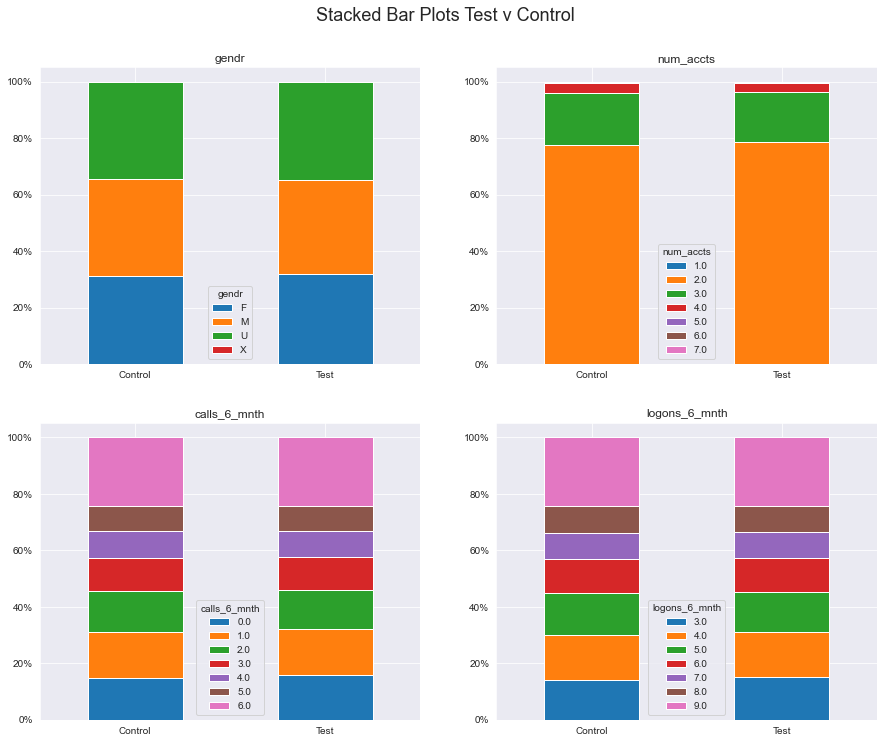

In [4]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Stacked Bar Plots Test v Control", fontsize=18, y=0.95)

feats = ['gendr', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']
for n, feat in enumerate(feats):
    # is gender balanced?
    x = data.drop(['visitor_id', 'visit_id', 'date_time'], axis=1).drop_duplicates().groupby(['Variation', '{}'.format(feat)]).gendr.count()

    # convert to dataframe, unstack and normalize
    x = pd.DataFrame(x).unstack()
    x['total'] = x.sum(axis=1)
    x = 100*x.gendr/x.total.values.reshape(-1,1)

    # stacked bar plot
    ax = plt.subplot(2, 2, n + 1)
    x.plot(kind='bar', stacked=True, ax=ax, rot=0)
    
    #set title
    ax.set_title('{}'.format(feat))
    ax.set_xlabel('')
    
    # format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# show plots
plt.show()

#
Check QQ-plots for test and control groups continuous variables. Everything looks pretty good. Balance has one blaring outlier, which should be removed.

Ttest_indResult(statistic=3.199508168297447, pvalue=0.0013768863912151012)
-0.11017036860033791
Ttest_indResult(statistic=3.099387208076646, pvalue=0.0019395442677518178)
-1.275126338466407
Ttest_indResult(statistic=2.8983470632096004, pvalue=0.003751852375981062)
-0.22418446739070674
Ttest_indResult(statistic=1.9806725446658078, pvalue=0.04762968701132109)
-2983.7435197443992


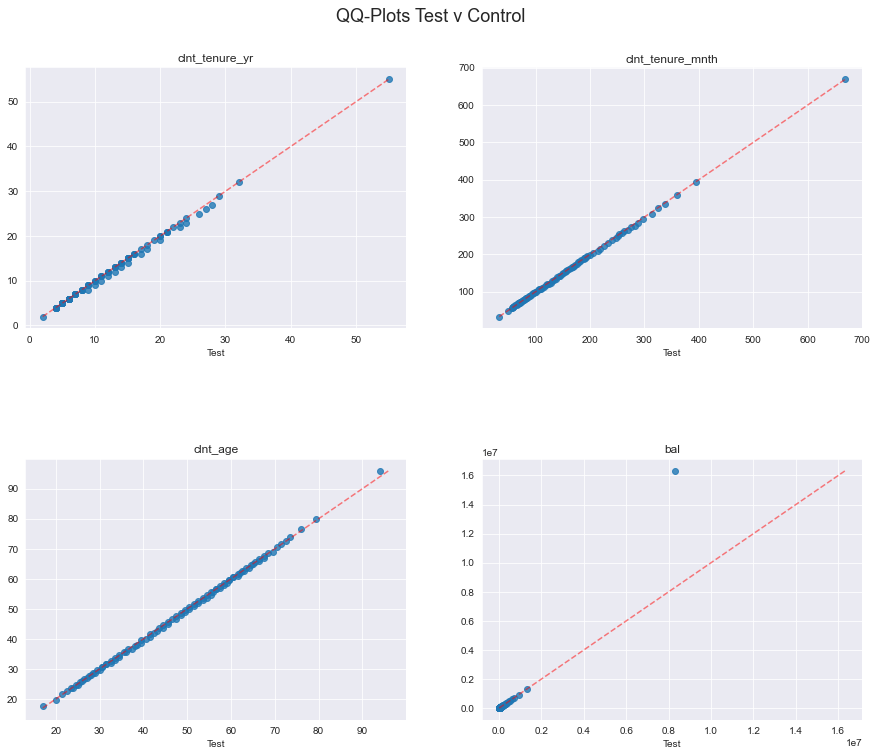

In [12]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("QQ-Plots Test v Control", fontsize=18, y=0.95)

# get data
feats = [x for x in df_demo.columns if x not in ['client_id', 'gendr']]
feats = ['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'bal']
for n, feat in enumerate(feats):
    y = data.drop(['visitor_id', 'visit_id', 'date_time'], axis=1).drop_duplicates()

    # qq-plot completion time ctrl vs test
    steps = 100
    ctrl_quantiles = [y.loc[y.Variation == 'Control', '{}'.format(feat)].quantile(x) for x in np.linspace(0, 1, steps)]
    test_quantiles = [y.loc[y.Variation == 'Test', '{}'.format(feat)].quantile(x) for x in np.linspace(0, 1, steps)]
    
    ax = plt.subplot(2, 2, n + 1)

    ax.scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

    x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
    ax.plot(x, x, c='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Control')
    ax.set_xlabel('Test')
    ax.set_title('{}'.format(feat))
    
    # check for equivalence of the means
    ctrl = y.loc[y.Variation == 'Control', '{}'.format(feat)]
    test =  y.loc[y.Variation == 'Test', '{}'.format(feat)]
    print(
        stats.ttest_ind(
            ctrl,
            test
        )
    )
    print(test.mean() - ctrl.mean())

#### Investigate web data
Count instances throughout process steps. We do not yet consider the possiblity of heterogeneity in treatments effects with demographics.

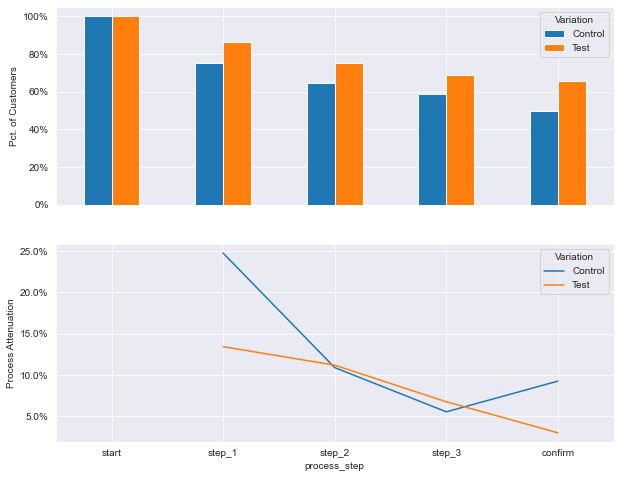

In [71]:
# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# cross tabulate and plot processes
data_ = data[['Variation', 'visit_id', 'process_step']].drop_duplicates()
ct = pd.crosstab(columns=data_.Variation, index=data_.process_step).copy()

# normalize counts 
ct = 100*ct/ct.loc['start']
ct = ct.reindex(['start', 'step_1', 'step_2', 'step_3', 'confirm'])
ct.plot.bar(rot=0, ax=ax[0])

# label graph
ax[0].set_ylabel('Pct. of Customers')
ax[1].set_xlabel('Process Step')

# plot attenuation curve
(-1*ct.diff()).plot(ax=ax[1])

ax[1].set_ylabel('Process Attenuation')

# format y-axis as percentage
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [75]:
# attenuation table
att_tab = -1*ct.diff().fillna(0)

# difference in differences
att_tab['DID'] = att_tab.Test - att_tab.Control

# show table
att_tab

Variation,Control,Test,DID
process_step,,,
start,-0.000000,-0.000000,0.000000
step_1,24.734333,13.426962,-11.307371
step_2,10.902173,11.196852,0.294678
step_3,5.558228,6.775214,1.216986
confirm,9.266629,3.021066,-6.245562


#### Understanding the data 
Will clients complete the process more than once?

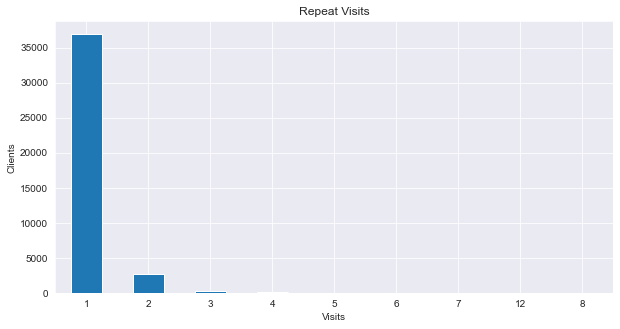

In [426]:
# will clients visit more than once?
# figure
fig, ax = plt.subplots(figsize=(10, 5))

# bar plot
data.groupby('client_id').visitor_id.nunique().value_counts().plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel('Clients')
ax.set_xlabel('Visits')
ax.set_title('Repeat Visits')

plt.show()

#
Are there more than 1 timestamps per process per visit_id? Yes, in a single visit a client can click multiple time, each of which is recorded as a timestamp.

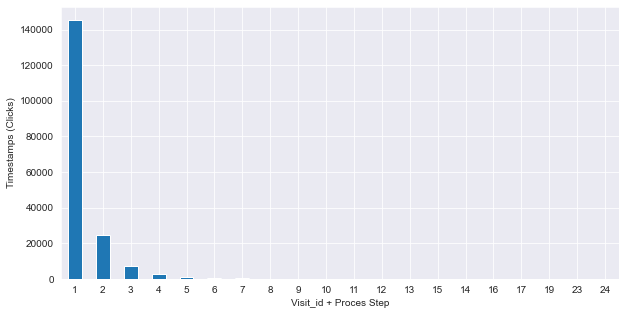

In [9]:
# Are there more than 1 timestamps per process per visit_id?
# figure
fig, ax = plt.subplots(figsize=(10, 5))
data.groupby(['visit_id', 'process_step']).date_time.nunique().value_counts().plot(kind='bar', rot=0, ax=ax)

ax.set_ylabel('Timestamps (Clicks)')
ax.set_xlabel('Visit_id + Proces Step')
plt.show()

In [464]:
# Are there more than 1 visitors per process_step per visit_id?
data.groupby(['visit_id', 'process_step']).visitor_id.nunique().value_counts()

# Answer: no

1    181835
Name: visitor_id, dtype: int64

#### Investigate covariates
Treatment assignment probabilities for all covariates

In [5]:
# probability of being assigned treatment 1 vs 0
df_treat = df_client.merge(df_demo, left_on='client_id', right_on='client_id', how='inner').drop_duplicates()
df_treat = df_treat.drop('client_id', axis=1)

# binarize treatment variable: 1 = Test, 0 = Control
df_treat['Variation'] = np.where(
    df_treat['Variation'] == 'Test', 1, 0
).astype(int)

df_treat.head()

,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,1,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,1,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0
2,0,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0
3,1,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0
4,0,5.0,70.0,29.0,U,2.0,34254.54,0.0,3.0


#
Correlation heatmap. Logons_6_month and calls_6_month are highly collinear.
No correlation between covariates and binary treatment variables. Small correlation between age and tenure.

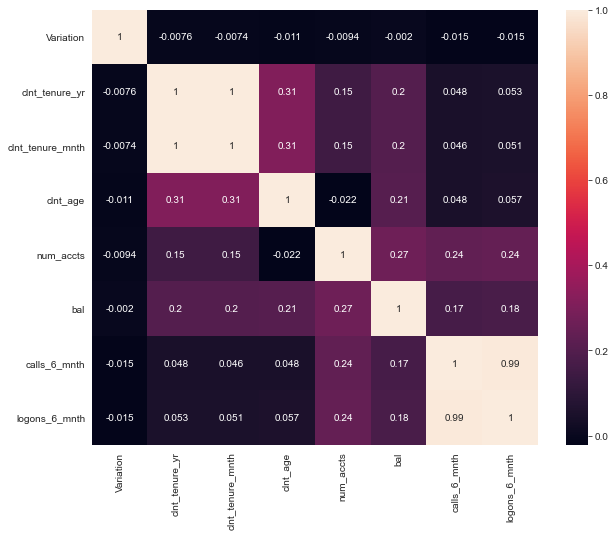

In [6]:
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(df_treat.corr(), annot=True, ax=ax)
plt.show()

#### Outcome Variables 

1. Completion Rate (binary 0 or 1)

2. Percent of Process Completed (20%, 40%, 60%, 80%)

3. Page Clicks (int)

In [5]:
# convert outvariable and treatment variables to integers
df_test = data.copy()

# convert process steps to integers
# binarize treatment variable: 1 = Test, 0 = Control
df_test['process_step'] = np.where(
    df_test['process_step'] == 'start', 0, 
    np.where(
        df_test['process_step'] == 'step_1', 1,
        np.where(
            df_test['process_step'] == 'step_2', 2,
            np.where(
                df_test['process_step'] == 'step_3', 3,
                    np.where(
                    df_test['process_step'] == 'confirm', 4, 'Other'
                )
            )
        )
    )
)

#convert to integer
df_test['process_step'] = df_test['process_step'].astype(int)

# get max step in the process for each visitor_id
df_test = df_test.groupby(['visit_id', 'Variation'] + df_demo.columns.tolist(), as_index=False)\
    .agg({'process_step':'max',
          'date_time':'nunique'
         })

# binary variable indicating if process was fully completed
df_test['complete'] = (df_test.process_step == 4).astype(int)

# rename aggregated columns
df_test.rename(columns={'process_step':'max_process_step', 'date_time':'clicks'}, inplace=True)

# binary variable indicating if the client moved past the initation (start) step
df_test['initiated'] = (df_test['max_process_step'] > 0).astype(int)

df_test.head()

,visit_id,Variation,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,max_process_step,clicks,complete,initiated
0,100012776_37918976071_457913,Test,3561384,4.0,56.0,59.5,U,2.0,63130.44,6.0,9.0,4,2,1,1
1,100019538_17884295066_43909,Test,7338123,7.0,88.0,23.5,M,2.0,26436.73,6.0,9.0,4,11,1,1
2,100030127_47967100085_936361,Control,105007,9.0,118.0,35.0,F,2.0,34897.47,3.0,6.0,0,1,0,0
3,100037962_47432393712_705583,Control,5623007,16.0,202.0,78.0,M,2.0,146827.14,5.0,8.0,1,4,0,1
4,100057941_88477660212_944512,Control,4823947,7.0,86.0,52.0,U,2.0,47340.11,5.0,8.0,3,7,0,1


#### Is the experimental design effective?
If randomiziation was done properly then there should be no systematic differences in pretreatment characteristics between the control and treatment groups.

Textbook for Causal Inference in Python: https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html

#### Completion Rate
Average Treament Effect (ATE) $E[Y:T=1] - E[Y|T=0]$ is estimated to be 0.1058.

In [133]:
# copy df_test
df_prop = df_test.copy()

# drop X gendr
df_prop = df_prop[df_prop.gendr != 'X']

# binarize treatment variable
df_prop['Variation'] = np.where(
    df_prop['Variation'] == 'Test', 1, 
    np.where(
        df_prop['Variation'] == 'Control', 
        0, np.nan
    )   
).astype(int)

fields = \
[
    'Variation',
    'clnt_tenure_yr',
    'clnt_age',
    'initiated',
    'clicks',
    'gendr',
    'num_accts',
    'max_process_step',
    'bal',
    'calls_6_mnth',
    'complete'
]

df_prop = df_prop[fields]

df_prop.head()

,Variation,clnt_tenure_yr,clnt_age,initiated,clicks,gendr,num_accts,max_process_step,bal,calls_6_mnth,complete
0,1,4.0,59.5,1,2,U,2.0,4,63130.44,6.0,1
1,1,7.0,23.5,1,11,M,2.0,4,26436.73,6.0,1
2,0,9.0,35.0,0,1,F,2.0,0,34897.47,3.0,0
3,0,16.0,78.0,1,4,M,2.0,1,146827.14,5.0,0
4,0,7.0,52.0,1,7,U,2.0,3,47340.11,5.0,0


In [130]:
# fit linear regression
smf.ols('complete ~ Variation', data=df_prop.dropna()).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4869,0.003,150.207,0.000,0.481,0.493
Variation,0.1058,0.004,24.241,0.000,0.097,0.114


In [134]:
# binary vectorize categorical variables
categ = ["gendr"]
cont = ['Variation', 'clnt_tenure_yr', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth']

data_with_categ = pd.concat([
    df_prop.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(df_prop[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

data_with_categ.head()

,Variation,clnt_tenure_yr,clnt_age,initiated,clicks,num_accts,max_process_step,bal,calls_6_mnth,complete,gendr_F,gendr_M,gendr_U
0,1,4.0,59.5,1,2,2.0,4,63130.44,6.0,1,0,0,1
1,1,7.0,23.5,1,11,2.0,4,26436.73,6.0,1,0,1,0
2,0,9.0,35.0,0,1,2.0,0,34897.47,3.0,0,1,0,0
3,0,16.0,78.0,1,4,2.0,1,146827.14,5.0,0,0,1,0
4,0,7.0,52.0,1,7,2.0,3,47340.11,5.0,0,0,0,1


In [135]:
# propensity score estimation
from sklearn.linear_model import LogisticRegression

T = 'Variation'
Y = 'complete'
X = data_with_categ.columns.drop([T, Y])

# fit LR model
ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

# copy df_prop to data_ps, add PS column 
data_ps = df_prop.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

# use PS to reduce dimensionality of covariate space
data_ps[["Variation", "complete", "propensity_score"]].head()

,Variation,complete,propensity_score
0,1,1,0.504359
1,1,1,0.501825
2,0,0,0.502410
3,0,0,0.510137
4,0,0,0.503269


In [18]:
# means over variation in outcome variables
print('Steps')
print(df_test.groupby('Variation').max_process_step.mean().diff())
print('Completion Rate')
print(df_test.groupby('Variation').complete.mean())
print('Clicks')
print(df_test.groupby('Variation').clicks.mean())
print('Completion rate s.t. that made it past step 0')
print(df_test[df_test.max_process_step >= 1].groupby('Variation').complete.mean())

Steps
Variation
Control         NaN
Test       0.475033
Name: max_process_step, dtype: float64
Completion Rate
Variation
Control    0.486928
Test       0.592665
Name: complete, dtype: float64
Clicks
Variation
Control    4.292088
Test       4.830141
Name: clicks, dtype: float64
Completion rate s.t. that made it past step 0
Variation
Control    0.648274
Test       0.678473
Name: complete, dtype: float64


#### Estimate Average Treatment Effects

#
When we include propensity score our estimate of the ATE remains stable at 0.1058.

In [38]:
# estimate treatment effect on completion rate
smf.ols("complete ~ Variation + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5848,0.052,11.206,0.000,0.482,0.687
Variation,0.1058,0.004,24.246,0.000,0.097,0.114
propensity_score,-0.1914,0.102,-1.879,0.060,-0.391,0.008


In [39]:
# estimate treatment effect on max steps completed
smf.ols("max_process_step ~ Variation + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.8860,0.168,17.190,0.000,2.557,3.215
Variation,0.4752,0.014,33.857,0.000,0.448,0.503
propensity_score,-0.8342,0.328,-2.545,0.011,-1.477,-0.192


In [40]:
# estimate treatment effect on clicks
smf.ols("clicks ~ Variation + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.8739,0.292,20.123,0.000,5.302,6.446
Variation,0.5384,0.024,22.061,0.000,0.491,0.586
propensity_score,-3.0942,0.570,-5.430,0.000,-4.211,-1.977


In [136]:
# estimate treatment effect on initiation
smf.ols("initiated ~ Variation + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7775,0.040,19.392,0.000,0.699,0.856
Variation,0.1224,0.003,36.533,0.000,0.116,0.129
propensity_score,-0.0515,0.078,-0.658,0.510,-0.205,0.102


#### Conditional Average Treatment Effects

In [143]:
# conditional average treatment effect for confirmation
# condition on making past initiation
smf.ols("complete ~ Variation + propensity_score", data=data_ps[data_ps.max_process_step > 0]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7451,0.055,13.627,0.000,0.638,0.852
Variation,0.0302,0.005,6.511,0.000,0.021,0.039
propensity_score,-0.1893,0.107,-1.774,0.076,-0.398,0.020


In [144]:
# conditional average treatment effect for confirmation
# condition on making to at least step 3
smf.ols("complete ~ Variation + propensity_score", data=data_ps[data_ps.max_process_step >= 3]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8749,0.047,18.439,0.000,0.782,0.968
Variation,0.0078,0.004,1.921,0.055,-0.000,0.016
propensity_score,-0.0705,0.093,-0.760,0.447,-0.252,0.111


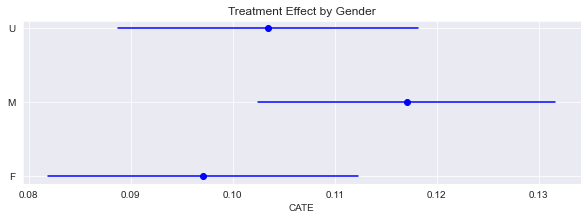

In [454]:
# conditional average treatment effect for confirmation
# condition female
fig, ax = plt.subplots(figsize=(10,3))
coefs = []
i = 1
for gendr in ['F', 'M', 'U']:
    result = smf.ols("complete ~ Variation + propensity_score", data=data_ps[data_ps.gendr == gendr]).fit()
    coef = result.params[1]
    l = result.conf_int().iloc[1].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
    i += 1

# format plot
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['F', 'M', 'U'])

ax.set_xlabel('CATE')
ax.set_title('Treatment Effect by Gender')

plt.show()

In [467]:
# conditional average treatment effect for confirmation
# condition female
age = 20
smf.ols("complete ~ Variation + propensity_score", data=data_ps[(data_ps.clnt_age >= age) & (data_ps.clnt_age < age + 10)]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1551,0.528,0.294,0.769,-0.881,1.191
Variation,0.1332,0.011,12.027,0.000,0.112,0.155
propensity_score,0.7507,1.048,0.717,0.474,-1.303,2.804


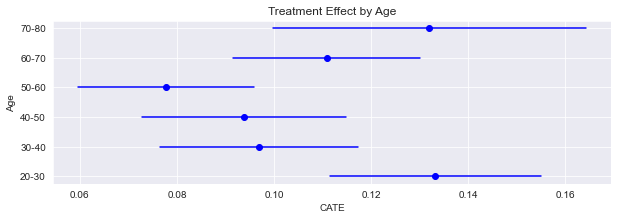

In [464]:
# conditional average treatment effect for confirmation
# condition female
fig, ax = plt.subplots(figsize=(10,3))
coefs = []
i = 1
for age in [20, 30, 40, 50, 60, 70]:
    result = smf.ols("complete ~ Variation + propensity_score", data=data_ps[(data_ps.clnt_age >= age) & (data_ps.clnt_age < age + 10)]).fit()
    coef = result.params[1]
    l = result.conf_int().iloc[1].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
    i += 1

# format
ax.set_yticks([1, 2, 3, 4, 5, 6])
ax.set_yticklabels(['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

ax.set_xlabel('CATE')
ax.set_ylabel('Age')
ax.set_title('Treatment Effect by Age')

plt.show()

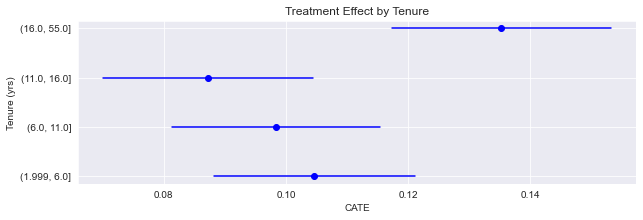

In [537]:
# tenure
# copy data and add qcut columns for tenure
df_ = data_ps.copy()
df_['tenure_cut'] = pd.qcut(data_ps.clnt_tenure_yr, 4)

fig, ax = plt.subplots(figsize=(10,3))
coefs = []
i = 1
tens = df_['tenure_cut'].unique().sort_values()
for ten in tens:
    result = smf.ols("complete ~ Variation + propensity_score", data=df_[df_.tenure_cut == ten]).fit()
    coef = result.params[1]
    l = result.conf_int().iloc[1].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
    i += 1
    
# format
ax.set_yticks([x + 1 for x in range(len(tens))])
ax.set_yticklabels([str(x) for x in tens])

ax.set_xlabel('CATE')
ax.set_ylabel('Tenure (yrs)')
ax.set_title('Treatment Effect by Tenure')

plt.show()

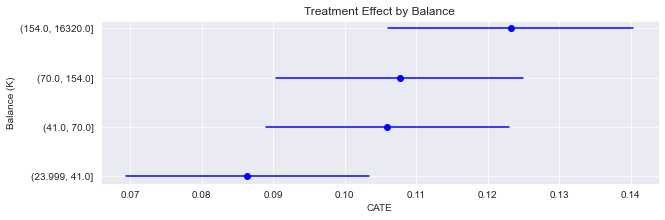

In [567]:
# bal
# copy data and add qcut columns for tenure
df_ = data_ps.copy()
df_['tenure_cut'] = pd.qcut((data_ps.bal/1000).round(), 4)

fig, ax = plt.subplots(figsize=(10,3))
coefs = []
i = 1
tens = df_['tenure_cut'].unique().sort_values()
for ten in tens:
    result = smf.ols("complete ~ Variation + propensity_score", data=df_[df_.tenure_cut == ten]).fit()
    coef = result.params[1]
    l = result.conf_int().iloc[1].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
    i += 1
    
# format
ax.set_yticks([x + 1 for x in range(len(tens))])
ax.set_yticklabels([str(x) for x in tens])

ax.set_xlabel('CATE')
ax.set_ylabel('Balance (K)')
ax.set_title('Treatment Effect by Balance')

plt.show()

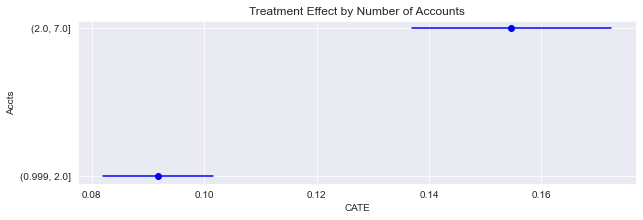

In [575]:
# num_accts
# copy data and add qcut columns for tenure
df_ = data_ps.copy()
df_['tenure_cut'] = pd.qcut(data_ps.num_accts, 2)

fig, ax = plt.subplots(figsize=(10,3))
coefs = []
i = 1
tens = df_['tenure_cut'].unique().sort_values()
for ten in tens:
    result = smf.ols("complete ~ Variation + propensity_score", data=df_[df_['tenure_cut'] == ten]).fit()
    coef = result.params[1]
    l = result.conf_int().iloc[1].tolist()
    ax.plot(l, [i, i], c='blue')
    ax.scatter(coef, i, c='blue')
    
    i += 1
    
# format
ax.set_yticks([x + 1 for x in range(len(tens))])
ax.set_yticklabels([str(x) for x in tens])

ax.set_xlabel('CATE')
ax.set_ylabel('Accts')
ax.set_title('Treatment Effect by Number of Accounts')

plt.show()

#### Visualize Treatment Effect on Process Completion

#
In the test group, most clients make it to 3rd and 4th steps within the process. Whereas in the control group the distribution is wider, with many clients halting at the 1st step.

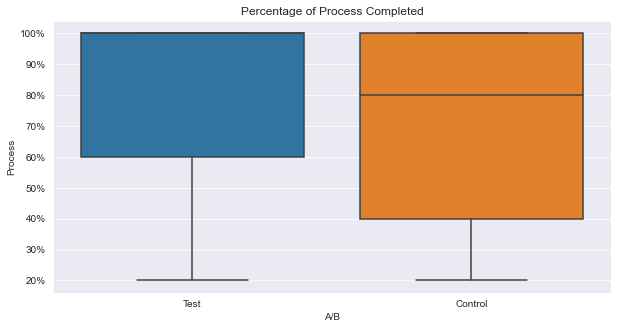

In [10]:
# create figure
fig, ax = plt.subplots(figsize=(10,5))

# convert max_process_step to percentage of journey completed
df_test_ = df_test.copy()
df_test_.max_process_step = 100*(df_test_.max_process_step/5 +0.2)

# boxplot
sns.boxplot(data=df_test_, x='Variation', y='max_process_step', ax=ax)

# format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# label axes
ax.set_title('Percentage of Process Completed')
ax.set_ylabel('Process')
ax.set_xlabel('A/B')
plt.show()

#
t-test for statistical difference in means: results are statistically significant.

In [193]:
# steps averages
from scipy import stats
t_stat, p_value = stats.ttest_ind(
    df_test.loc[df_test.Variation == 'Control', 'process_step'], 
    df_test.loc[df_test.Variation == 'Test', 'process_step']
)

# print results
ctrl = df_test.loc[df_test.Variation == 'Control', 'process_step'].mean()
test = df_test.loc[df_test.Variation == 'Test', 'process_step'].mean()

print('Average Final Process Step Per Visit:')

print()
print('Control:', round(ctrl, 3))
print('Test:', round(test, 3))

print()
print('Improvement:', test - ctrl)
print('Significance:', p_value)

Average Final Process Step Per Visit:

Control: 2.46
Test: 2.935

Improvement: 0.4750327209480134
Significance: 2.3223089567232457e-248


In [194]:
# copmletion averages
from scipy import stats
t_stat, p_value = stats.ttest_ind(
    df_test.loc[df_test.Variation == 'Control', 'complete'], 
    df_test.loc[df_test.Variation == 'Test', 'complete']
)

# print results
ctrl = df_test.loc[df_test.Variation == 'Control', 'complete'].mean()
test = df_test.loc[df_test.Variation == 'Test', 'complete'].mean()
print('Average Final Process Step Per Visit:')
print()
print('Control:', round(ctrl, 3))
print('Test:', round(test, 3))
print()
print('Improvement:', str(round(100*(test - ctrl), 1)) + '%')
print('Significance:', p_value)

Average Final Process Step Per Visit:

Control: 0.487
Test: 0.593

Improvement: 10.6%
Significance: 4.7398779182637933e-129


#### Pain Points
Where are clients most likely to stop in the process?

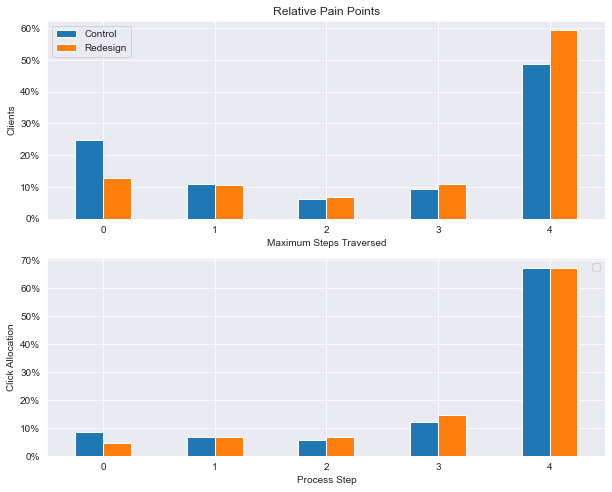

In [164]:
# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# identify pain points in process
x = df_test.groupby(['Variation', 'max_process_step']).max_process_step.count().unstack()

# normalize
x.iloc[0] = 100*x.iloc[0]/x.sum(axis=1)[0]
x.iloc[1] = 100*x.iloc[1]/x.sum(axis=1)[1]

# stacked bar plot
x.T.plot(kind='bar', rot=0, ax=ax[0])

# labels
ax[0].set_title('Relative Pain Points')
ax[0].legend(['Control', 'Redesign'])
ax[0].set_ylabel('Clients')
ax[0].set_xlabel('Maximum Steps Traversed')

# click allocation
y = df_test.groupby(['Variation', 'max_process_step']).clicks.sum().unstack()

# normalize
y.iloc[0] = 100*y.iloc[0]/y.sum(axis=1)[0]
y.iloc[1] = 100*y.iloc[1]/y.sum(axis=1)[1]

y.T.plot(kind='bar', rot=0, ax = ax[1])

ax[1].set_ylabel('Click Allocation')

# format y-axis as percentage
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

# label axis
ax[1].set_xlabel('Process Step')
ax[1].legend([])

plt.show()

#### Clicks
Look at click distribution within steps and changes in click behavior.

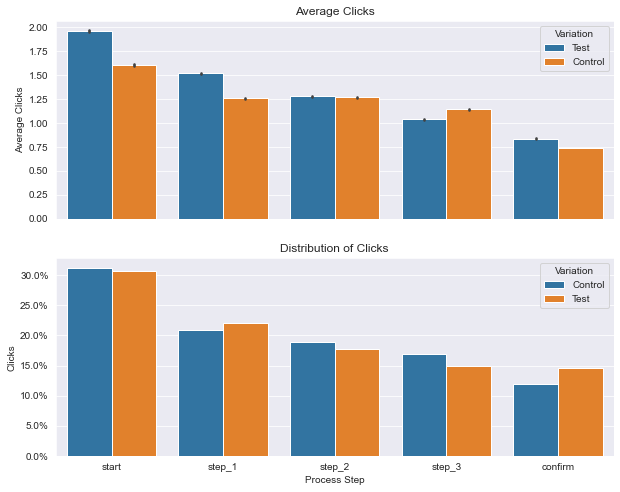

In [281]:
# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# steps + visit = idx
steps = data.process_step.unique()
visits = data.visit_id.unique()

# create multi-index
idx = pd.MultiIndex.from_product((steps, visits), names=['process_step', 'visit_id'])

x = data.groupby(['process_step', 'visit_id'], as_index=False).agg({'date_time':'nunique'})
x.rename(columns={'date_time':'clicks'}, inplace=True)
x.drop_duplicates(inplace=True)

# fill in missing steps
x = x.set_index(['process_step', 'visit_id']).reindex(idx, fill_value=0).reset_index()

# get variation from data
x = x.merge(data[['visit_id', 'Variation']], left_on='visit_id', right_on='visit_id', how='left')

# bar plot average clicks
order=['start', 'step_1', 'step_2', 'step_3', 'confirm']
sns.barplot(data=x, x='process_step', y='clicks', hue='Variation', order=order, ax=ax[0])

# labels
ax[0].set_ylabel('Average Clicks')
ax[0].set_xlabel('')
ax[0].set_title('Average Clicks')

# distribution of clicks
y = data.groupby(['Variation', 'process_step'], as_index=False).date_time.nunique()
y.rename(columns={'date_time':'clicks'}, inplace=True)

# normalize
y.loc[y.Variation == 'Control', 'clicks'] = 100*y.loc[y.Variation == 'Control', 'clicks']/y.loc[y.Variation == 'Control', 'clicks'].sum()
y.loc[y.Variation == 'Test', 'clicks'] = 100*y.loc[y.Variation == 'Test', 'clicks']/y.loc[y.Variation == 'Test', 'clicks'].sum()

sns.barplot(data=y, x='process_step', y='clicks', hue='Variation', order=order, ax=ax[1])
ax[1].set_title('Distribution of Clicks')
ax[1].set_ylabel('Clicks')
ax[1].set_xlabel('Process Step')

ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [295]:
avg_clicks = x.groupby(['Variation', 'process_step']).clicks.mean().unstack().T
avg_clicks['delta (%)'] = 100*(avg_clicks.Test - avg_clicks.Control)/avg_clicks.Control

avg_clicks.reindex(order)

Variation,Control,Test,delta (%)
process_step,,,
start,1.603635,1.956083,21.978043
step_1,1.255612,1.515283,20.680845
step_2,1.265105,1.277706,0.996083
step_3,1.139874,1.036614,-9.058890
confirm,0.735882,0.834224,13.363863


#### Age and Completion Rate

Test correlation: -0.09904547672379689
Control correlation -0.10240881535427775

count    70594.000000
mean        46.442240
std         15.591273
min         13.500000
25%         32.500000
50%         47.000000
75%         59.000000
max         96.000000
Name: clnt_age, dtype: float64


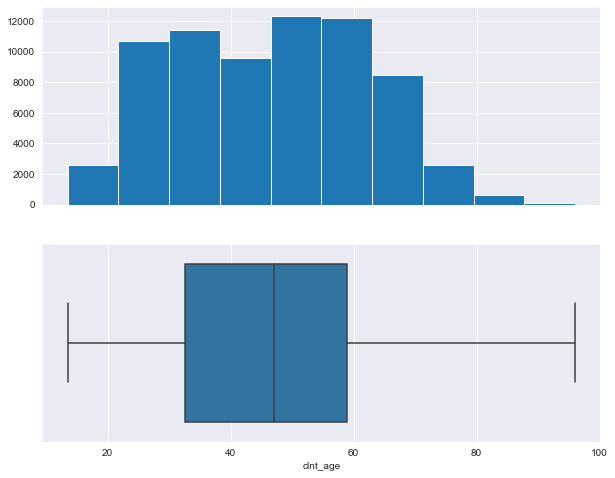

In [540]:
# correlation
print(
    'Test correlation:',
    df_test.loc[df_test.Variation =='Test', ['clnt_age', 'complete']].corr().iloc[1,0]
)
print(
    'Control correlation',
    df_test.loc[df_test.Variation =='Control', ['clnt_age', 'complete']].corr().iloc[1,0]
)

# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# histogram and boxplot of age
df_demo.clnt_age.hist(ax=ax[0])
sns.boxplot(data=df_demo, x='clnt_age', ax=ax[1])

print()
print(df_demo.clnt_age.describe())
plt.show()

#### Tenure

Test correlation: -0.0077550794955534045
Control correlation -0.027830886791816896

count    70594.000000
mean        12.053007
std          6.871850
min          2.000000
25%          6.000000
50%         11.000000
75%         16.000000
max         62.000000
Name: clnt_tenure_yr, dtype: float64


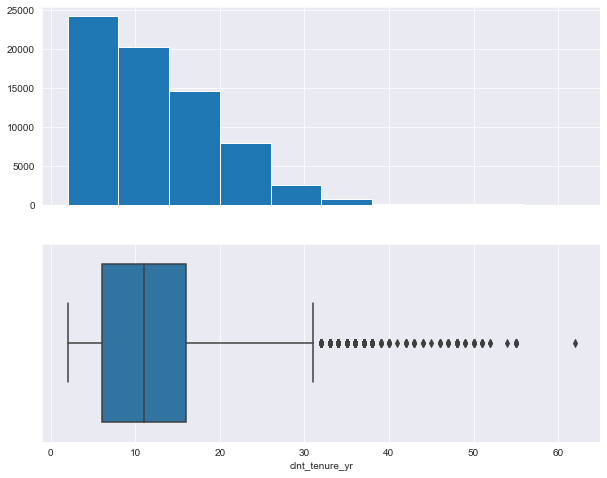

In [547]:
# correlation
print(
    'Test correlation:',
    df_test.loc[df_test.Variation =='Test', ['clnt_tenure_yr', 'complete']].corr().iloc[1,0]
)
print(
    'Control correlation',
    df_test.loc[df_test.Variation =='Control', ['clnt_tenure_yr', 'complete']].corr().iloc[1,0]
)

# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# histogram and boxplot of age
df_demo.clnt_tenure_yr.hist(ax=ax[0])
sns.boxplot(data=df_demo, x='clnt_tenure_yr', ax=ax[1])

print()
print(df_demo.clnt_tenure_yr.describe())
plt.show()

#### Balance

Test correlation: 0.009288724447291629
Control correlation -0.02458644518714655

count    7.059400e+04
mean     1.474467e+05
std      3.015106e+05
min      1.378942e+04
25%      3.734660e+04
50%      6.333459e+04
75%      1.375461e+05
max      1.632004e+07
Name: bal, dtype: float64


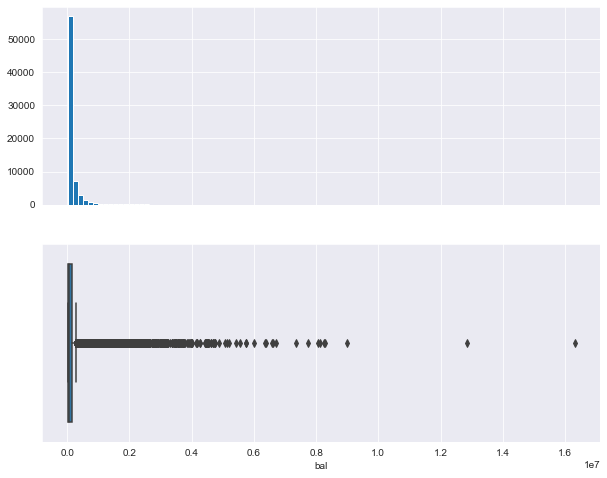

In [550]:
# correlation
print(
    'Test correlation:',
    df_test.loc[df_test.Variation =='Test', ['bal', 'complete']].corr().iloc[1,0]
)
print(
    'Control correlation',
    df_test.loc[df_test.Variation =='Control', ['bal', 'complete']].corr().iloc[1,0]
)

# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# histogram and boxplot of age
df_demo.bal.hist(bins=100, ax=ax[0])
sns.boxplot(data=df_demo, x='bal', ax=ax[1])

print()
print(df_demo.bal.describe())
plt.show()

#### Number of Accounts

Test correlation: 0.05828328730430324
Control correlation 0.0010410977198112331

count    70594.000000
mean         2.255532
std          0.535000
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          8.000000
Name: num_accts, dtype: float64


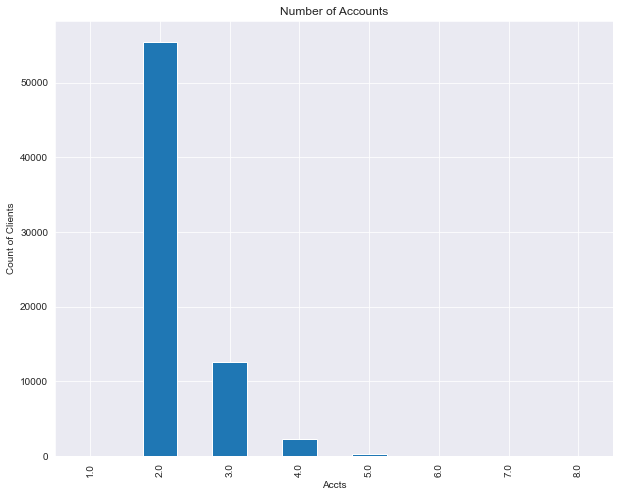

In [562]:
# correlation
print(
    'Test correlation:',
    df_test.loc[df_test.Variation =='Test', ['num_accts', 'complete']].corr().iloc[1,0]
)
print(
    'Control correlation',
    df_test.loc[df_test.Variation =='Control', ['num_accts', 'complete']].corr().iloc[1,0]
)

# create figure
fig, ax = plt.subplots(figsize=(10, 8), sharex=True)

# histogram and boxplot of age
df_demo.num_accts.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Accounts')
ax.set_ylabel('Count of Clients')
ax.set_xlabel('Accts')

print()
print(df_demo.num_accts.describe())
plt.show()

In [ ]:
# correlation
print(
    'Test correlation:',
    df_test.loc[df_test.Variation =='Test', ['clnt_tenure_yr', 'complete']].corr().iloc[1,0]
)
print(
    'Control correlation',
    df_test.loc[df_test.Variation =='Control', ['clnt_tenure_yr', 'complete']].corr().iloc[1,0]
)

# create figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# histogram and boxplot of age
df_demo.clnt_tenure_yr.hist(ax=ax[0])
sns.boxplot(data=df_demo, x='clnt_tenure_yr', ax=ax[1])

print()
print(df_demo.clnt_tenure_yr.describe())
plt.show()

#### Gender

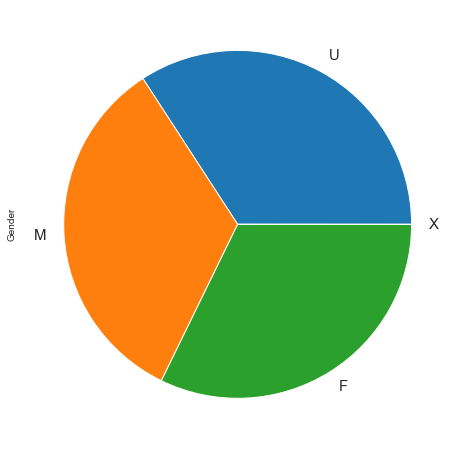

In [384]:
# create figure
fig, ax = plt.subplots(figsize=(10, 8))

df_demo.gendr.value_counts().plot(kind='pie', fontsize=15)
ax.set_ylabel('Gender')
plt.show()

#### Completion Time

In [351]:
# compute overall change in process time
# get features
df_ttime = data[['visit_id', 'process_step', 'date_time', 'Variation']].copy()

# merge min time in each process step, including confirm, with max time in confirm step
df_ttime = pd.crosstab(
    index=df_ttime.visit_id, columns=df_ttime.process_step, values=df_ttime.date_time, aggfunc=min
)\
    .merge(
    df_ttime[df_ttime.process_step == 'confirm'].groupby(['visit_id', 'Variation'], as_index=False).date_time.max(),
    left_on='visit_id',
    right_on='visit_id',
    how='left'
)

# rename column
df_ttime.rename(columns={'date_time':'max_date'}, inplace=True)

# reorder columns
df_ttime = df_ttime[['visit_id', 'Variation', 'start', 'step_1', 'step_2', 'step_3', 'confirm', 'max_date']]
df_ttime.head()

# total process completion time in minutes
df_ttime['completion_time'] = (df_ttime['max_date'] - df_ttime['start']).dt.total_seconds()/60

df_ttime.head()

,visit_id,Variation,start,step_1,step_2,step_3,confirm,max_date,completion_time
0,100012776_37918976071_457913,Test,NaT,NaT,NaT,NaT,2017-04-26 13:22:17,2017-04-26 13:23:09,NaN
1,100019538_17884295066_43909,Test,2017-04-09 16:20:56,2017-04-09 16:21:12,2017-04-09 16:21:21,2017-04-09 16:24:01,2017-04-09 16:24:58,2017-04-09 16:24:58,4.033333
2,100030127_47967100085_936361,NaN,2017-03-22 11:07:49,NaT,NaT,NaT,NaT,NaT,NaN
3,100037962_47432393712_705583,NaN,2017-04-14 16:41:51,2017-04-14 16:43:55,NaT,NaT,NaT,NaT,NaN
4,100057941_88477660212_944512,NaN,2017-04-09 11:30:10,2017-04-09 11:30:40,2017-04-09 11:31:50,2017-04-09 11:32:54,NaT,NaT,NaN


# 
Histograms and qq-plot indicate that completion time distributions between test and control groups do no vary significantly, aside from a slide shift down in the test groups completion time.

Completion Time
           completion_time
Variation                 
Control           6.470652
Test              6.071645

Median Completion Time
Variation
Control    4.833333
Test       3.683333
Name: completion_time, dtype: float64

Ttest_indResult(statistic=-5.992533301288501, pvalue=2.0943250439995332e-09)


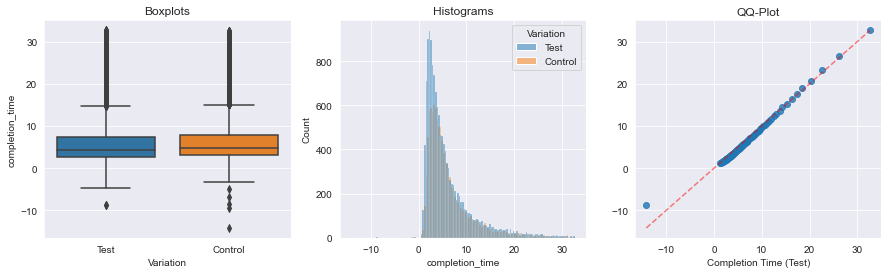

In [437]:
# boxplot completion time
# keep only completed journeys, drop outliers
df_ttime_ =  df_ttime[
    (~df_ttime.completion_time.isna())
].reset_index(drop=True)

#drop outliers
df_ttime_ = df_ttime_[(np.abs(stats.zscore(df_ttime_.completion_time)) < 3)]

# boxplot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=df_ttime_[~df_ttime_.completion_time.isna()], x='Variation', y='completion_time', ax=ax[0])
ax[0].set_title('Boxplots')

# get average completion times
print('Completion Time')
print(df_ttime_[~df_ttime_.completion_time.isna()].groupby('Variation').mean())

# print median time per step
print()
print('Median Completion Time')
print(df_time.groupby('Variation').completion_time.median())

# 2-sample t-test
print()
print(
    stats.ttest_ind(
        df_ttime_.loc[(~df_ttime_.completion_time.isna()) & (df_ttime_.Variation == 'Test'), 'completion_time'],
        df_ttime_.loc[(~df_ttime_.completion_time.isna()) & (df_ttime_.Variation == 'Control'), 'completion_time']
    )
)

# compare completion time histograms ctrl vs test
sns.histplot(data=df_ttime_, x='completion_time', hue='Variation', ax=ax[1])
ax[1].set_title('Histograms')

# qq-plot completion time ctrl vs test
steps = 100
ctrl_quantiles = [df_ttime_.loc[df_ttime_.Variation == 'Control', 'completion_time'].quantile(x) for x in np.linspace(0, 1, steps)]
test_quantiles = [df_ttime_.loc[df_ttime_.Variation == 'Test', 'completion_time'].quantile(x) for x in np.linspace(0, 1, steps)]

ax[2].scatter(ctrl_quantiles, test_quantiles, alpha=0.8)

x = np.linspace(min([min(ctrl_quantiles), min(test_quantiles)]), max([max(ctrl_quantiles), max(test_quantiles)]))
ax[2].plot(x, x, c='red', linestyle='--', alpha=0.5)
ax[2].set_xlabel('Completion Time (Control)')
ax[2].set_xlabel('Completion Time (Test)')
ax[2].set_title('QQ-Plot')

plt.show()

#### Time per Step
After further analysis it appears that the time per step is not reasonable to look at. We only have timestamps on clicks and apparently a client can go backwards in steps as well as forwards.

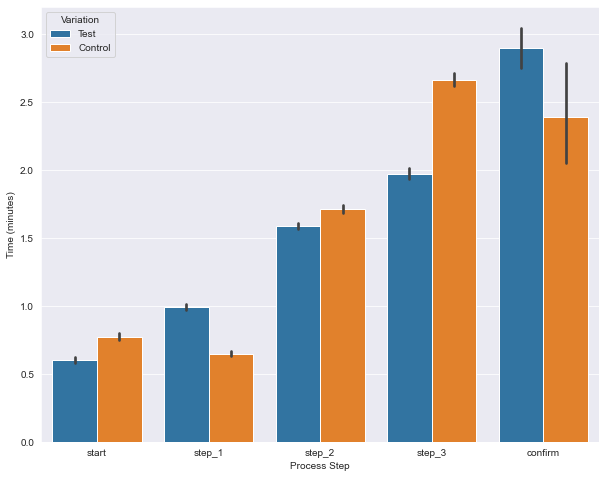

In [542]:
# get features
df_time = data[['visit_id', 'process_step', 'date_time', 'Variation']].copy()

# merge min time in each process step, including confirm, with max time in confirm step
df_time = pd.crosstab(
    index=df_time.visit_id, columns=df_time.process_step, values=df_time.date_time, aggfunc=min
)\
    .merge(
    df_time[df_time.process_step == 'confirm'].groupby(['visit_id', 'Variation'], as_index=False).date_time.max(),
    left_on='visit_id',
    right_on='visit_id',
    how='inner'
)

# get completion time for complete journeys
df_time['completion_time'] = (df_time.confirm - df_time.start).dt.total_seconds()/60

# drop incomplete journeys, or journeys with incomplete data
df_time = df_time[~df_time.completion_time.isna()]

# rename column
df_time.rename(columns={'date_time':'max_confirm'}, inplace=True)

# get time deltas
df_time['start_'] = df_time.step_1 - df_time.start
df_time['step_1_'] = df_time.step_2 - df_time.step_1
df_time['step_2_'] = df_time.step_3 - df_time.step_2
df_time['step_3_'] = df_time.confirm - df_time.step_3
df_time['confirm_'] = df_time.max_confirm - df_time.confirm

a = df_time[['start_', 'Variation']].dropna().copy()
a.loc[:, 'process_step'] = 'start'
a.rename(columns={'start_': 'time'}, inplace=True)

b = df_time[['step_1_', 'Variation']].dropna().copy()
b.loc[:, 'process_step'] = 'step_1'
b.rename(columns={'step_1_': 'time'}, inplace=True)

c = df_time[['step_2_', 'Variation']].dropna().copy()
c.loc[:, 'process_step'] = 'step_2'
c.rename(columns={'step_2_': 'time'}, inplace=True)

d = df_time[['step_3_', 'Variation']].dropna().copy()
d.loc[:, 'process_step'] = 'step_3'
d.rename(columns={'step_3_': 'time'}, inplace=True)

e = df_time[['confirm_', 'Variation']].dropna().copy()
e.loc[:, 'process_step'] = 'confirm'
e.rename(columns={'confirm_': 'time'}, inplace=True)

#drop outliers
a = a[(np.abs(stats.zscore(a.time.dt.total_seconds())) < 3)]
b = b[(np.abs(stats.zscore(b.time.dt.total_seconds())) < 3)]
c = c[(np.abs(stats.zscore(c.time.dt.total_seconds())) < 3)]
d = d[(np.abs(stats.zscore(d.time.dt.total_seconds())) < 3)]
e = e[(np.abs(stats.zscore(e.time.dt.total_seconds())) < 3)]

# stack
result = pd.DataFrame()
for df in [a, b, c, d, e]:
    result = pd.concat([result, df], axis=0)

# step time
result['time'] = result['time'].dt.total_seconds()/60

# filter negative times
result = result[result.time > 0]

# create figure
fig, ax = plt.subplots(figsize=(10, 8))

# boxplot
sns.barplot(data=result, x='process_step', y='time', hue='Variation', order=['start', 'step_1', 'step_2', 'step_3', 'confirm'])
ax.set_ylabel('Time (minutes)')
ax.set_xlabel('Process Step')

plt.show()

In [832]:
# unstack
x = result.groupby(['process_step', 'Variation']).time.mean().unstack()

# compute difference in averages 
x['AB_time_delta'] = x.Test - x.Control
x['AB_time_delta_pct'] = 100*x['AB_time_delta']/x.Control

# show result
print(x)

Variation      Control      Test  AB_time_delta  AB_time_delta_pct
process_step                                                      
confirm       0.117305  0.718823       0.601518         512.781811
start         1.085554  0.811003      -0.274551         -25.291304
step_1        0.758519  1.280944       0.522425          68.874355
step_2        1.833282  1.787039      -0.046243          -2.522412
step_3        3.078252  2.466348      -0.611905         -19.878313


#### Clicks per Process Step

Variation
Control    4.235595
Test       4.738017
dtype: float64

process_step
confirm    11.83
start      19.73
step_1     11.03
step_2     -2.58
step_3     -7.82
dtype: float64


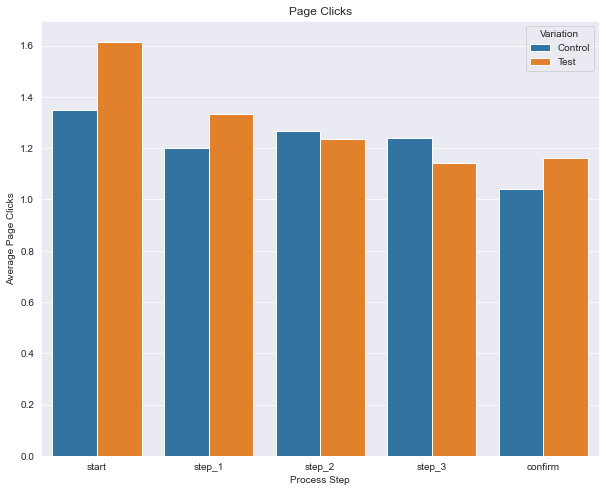

In [759]:
# hits per page
x = data.groupby(['Variation', 'process_step'], as_index=False).agg({'date_time':'nunique', 'visit_id':'nunique'})
x['avg_clicks'] = x.date_time/x.visit_id

# create figure
fig, ax = plt.subplots(figsize=(10, 8))

# barlpot
sns.barplot(data=x, x='process_step', y='avg_clicks', hue='Variation', order=['start', 'step_1', 'step_2', 'step_3', 'confirm'])
ax.set_ylabel('Average Page Clicks')
ax.set_xlabel('Process Step')
ax.set_title('Page Clicks')

# compare total average page clicks
print(x.groupby('Variation').date_time.sum()/data.groupby('Variation').visit_id.nunique())

print()
y = x.pivot(columns='Variation', index='process_step', values='avg_clicks')
print(round(100*(y.Test - y.Control)/y.Control, 2))

plt.show()

#
Test changes in average click rate for statistical significance.

1.3548588181437435 1.2621055409634163
7.349090402497154 %
Ttest_indResult(statistic=-24.106771523995853, pvalue=3.3756243702032576e-128)

start: Ttest_indResult(statistic=-28.258172824229383, pvalue=2.8859267115315362e-174)
step_1: Ttest_indResult(statistic=-19.576629028182193, pvalue=6.170864353333171e-85)
step_2: Ttest_indResult(statistic=4.156561670366395, pvalue=3.2385743872970345e-05)
step_3: Ttest_indResult(statistic=14.51551679861615, pvalue=1.3811131325600203e-47)
confirm: Ttest_indResult(statistic=-21.631532080748038, pvalue=6.186682876854916e-103)


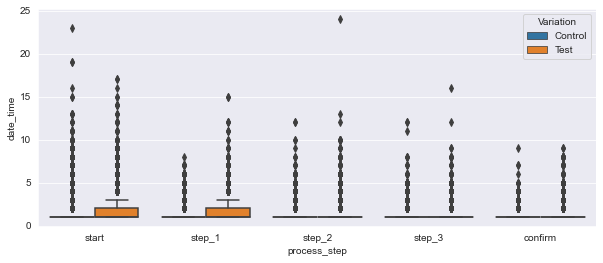

In [773]:
# group by visit_id and count unique page clicks
x = data.groupby(['Variation', 'process_step', 'visit_id'], as_index=False).agg({'date_time':'nunique'})

# get_control and test clicks
ctrl = x.loc[x.Variation == 'Control', 'date_time']
test = x.loc[x.Variation == 'Test', 'date_time']

# compute overal change in average click rate
print(test.mean(), ctrl.mean())
print(100*(test.mean() - ctrl.mean())/ctrl.mean(), '%')

# t-test for difference in means
print(
    stats.ttest_ind(
        x.loc[x.Variation == 'Control', 'date_time'],
        x.loc[x.Variation == 'Test', 'date_time']
    )
)
print()

# t-test for difference in means
for step in ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
    print(
        step + ':',
        stats.ttest_ind(
            x.loc[(x.Variation == 'Control') & (x.process_step == step), 'date_time'],
            x.loc[(x.Variation == 'Test') & (x.process_step == step), 'date_time']
        )
    )

# box plot for pages clicks per process step
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=x, x='process_step', y='date_time', hue='Variation', order=['start', 'step_1', 'step_2', 'step_3', 'confirm'])
plt.show()

#### Page Clicks over Covariates

In [609]:
# page clicks by gender, variation
pg_clicks = data.groupby(['visit_id', 'Variation'] + df_demo.columns.tolist(), as_index=False).date_time.nunique()
pg_clicks.rename(columns={'date_time':'pg_clicks'}, inplace=True)

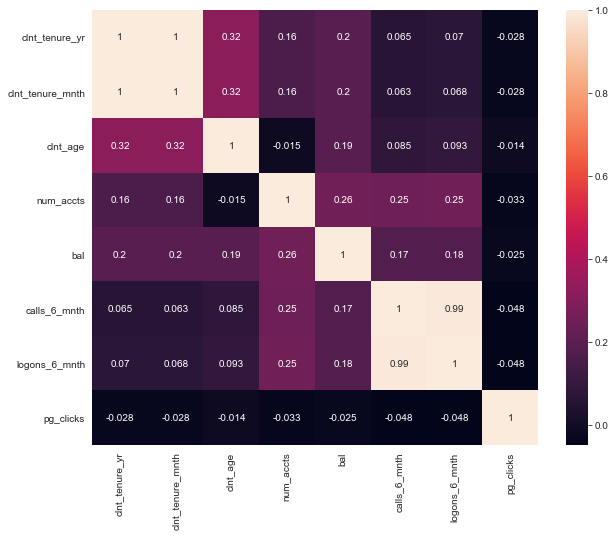

In [610]:
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(pg_clicks.drop('client_id', axis=1).corr(), annot=True, ax=ax)
plt.show()

#### Invetigate Completion Rate Dependence on Gender

Ctrl Chi2 Independence p-value: 0.0016552389087309063
Test Chi2 Independence p-value: 1.4839660871493105e-08


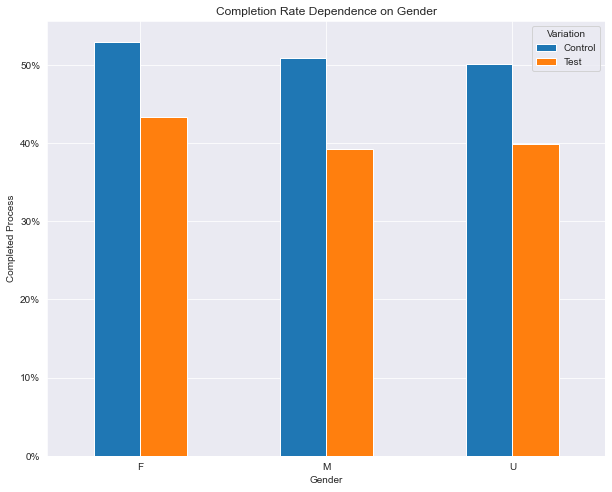

In [530]:
# contigency table for gender
ctrl = df_test[df_test.Variation == 'Control']
ctrl = pd.crosstab(columns=ctrl.gendr, index=df_test_.complete)

# chi2 independence test
chi2, p, dof, ex = stats.chi2_contingency(ctrl)
print('Ctrl Chi2 Independence p-value:', p)

# contingency table for redesign
test = df_test[df_test.Variation == 'Test']
test = pd.crosstab(columns=test.gendr, index=test.complete)

# chi2 independence test
chi2, p, dof, ex = stats.chi2_contingency(test)
print('Test Chi2 Independence p-value:', p)

ctrl = pd.DataFrame(ctrl.iloc[0]/(ctrl.iloc[0] + ctrl.iloc[1]))
ctrl['Variation'] = 'Control'
test = pd.DataFrame(test.iloc[0]/(test.iloc[0] + test.iloc[1]))
test['Variation'] = 'Test'

x = pd.concat([ctrl, test], axis=0).reset_index().pivot(columns='Variation', index='gendr', values=0)
x = x[x.index != 'X']
x = x*100

# figure
fig, ax = plt.subplots(figsize=(10,8))

# barplot
x.plot(kind='bar', rot=0, ax=ax)

# format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# labels
ax.set_ylabel('Completed Process')
ax.set_xlabel('Gender')
ax.set_title('Completion Rate Dependence on Gender')

plt.show()

In [611]:
# test for significance in difference in comlete rates for men and women
f_cmpl = df_test_.loc[df_test_.gendr == 'F', 'complete'].mean()
m_cmpl = df_test_.loc[df_test_.gendr == 'M', 'complete'].mean()

print(
    stats.ttest_ind(
        df_test_.loc[df_test_.gendr == 'F', 'complete'],
        df_test_.loc[df_test_.gendr == 'M', 'complete']
    )
)

100*(f_cmpl - m_cmpl)

Ttest_indResult(statistic=-2.5391457279253014, pvalue=0.01112207975398282)


-2.0434076792772427

#### PCA

                       0         1         2         3
clnt_tenure_yr  0.791509 -0.154315 -0.062325  0.004752
clnt_age        0.500729 -0.138407  0.051490 -0.056115
num_accts       0.300003  0.398339  0.543497  0.039315
bal             0.431692  0.326740  0.418868 -0.002508
logons_6_mnth   0.226663  0.436222  0.472404  0.002225
gendr_F         0.310741 -0.852050  0.334479  0.013764
gendr_M         0.534387  0.582508 -0.589376 -0.003650
gendr_U        -0.836906  0.256331  0.258690 -0.019939
gendr_X        -0.005907 -0.003890 -0.019830  0.997498



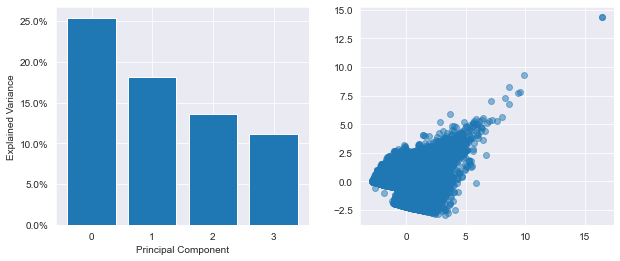

In [701]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# pca
pca = PCA(n_components=4)
df_pca = df_test[['complete'] + df_demo.columns.tolist()]

# one-hot vectorize categorical variables'
df_pca = pd.get_dummies(df_pca)

# drop calls_6_month because it is collinear with logons_6_month
# and dnt_tenure_month for the same reason
X = df_pca.drop(['complete', 'calls_6_mnth', 'clnt_tenure_mnth', 'client_id'], axis=1)
y = df_pca.complete

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit data
X_pca = pca.fit_transform(X_scaled)

# extract loadings
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
loadings.index = X.columns

print(loadings)
print()

# plot explained variances
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar([str(x) for x in range(len(pca.explained_variance_ratio_))], 100*pca.explained_variance_ratio_)
ax[0].set_ylabel('Explained Variance')
ax[0].set_xlabel('Principal Component')

# format y-axis as percentage
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)

plt.show()

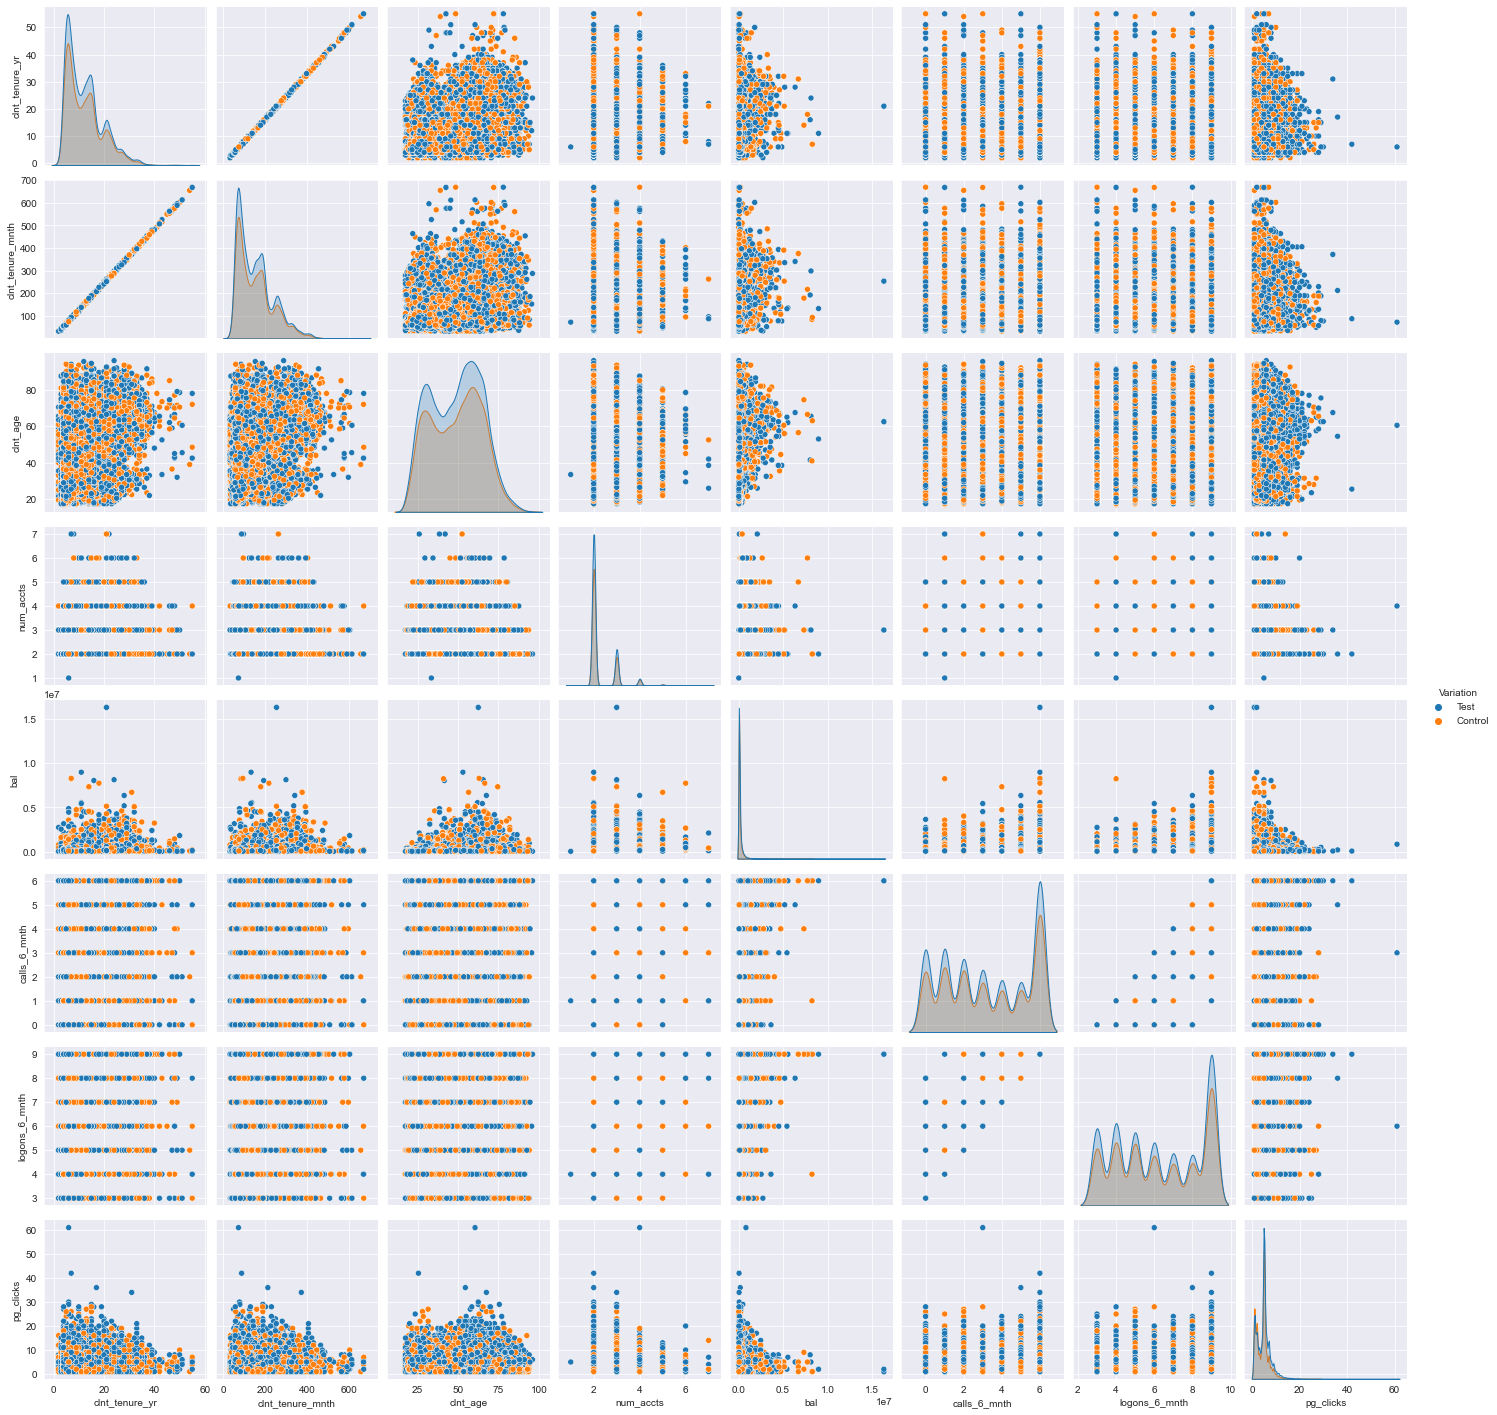

In [1037]:
# page clicks by gender, variation
pg_clicks = data.groupby(['visit_id', 'Variation'] + df_demo.columns.tolist(), as_index=False).date_time.nunique()
pg_clicks.rename(columns={'date_time':'pg_clicks'}, inplace=True)

# pair plot
sns.pairplot(data=pg_clicks.drop('client_id', axis=1), hue='Variation')
plt.show()